<a href="https://colab.research.google.com/github/kaisarfardin6620/NLP-based-Twitter-Sentiment-Analysis/blob/main/NLP_based_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud
!pip install imblearn
!pip install tensorflow
!pip install nltk

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/tweets/twitter_training.csv')

In [6]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df.columns = ['twee_id', 'entity', 'sentiment', 'tweet_content']

In [8]:
df.head()

,twee_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [9]:
df.tail()

,twee_id,entity,sentiment,tweet_content
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [10]:
df.shape

(74681, 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   twee_id        74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
df.describe()

,twee_id
count,74681.000000
mean,6432.640149
std,3740.423819
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [13]:
df.isnull().sum()

,0
twee_id,0
entity,0
sentiment,0
tweet_content,686


In [14]:
df = df.dropna()

In [15]:
df.isnull().sum()

,0
twee_id,0
entity,0
sentiment,0
tweet_content,0


In [16]:
df['sentiment'].value_counts()

,count
sentiment,
Negative,22358
Positive,20654
Neutral,18108
Irrelevant,12875


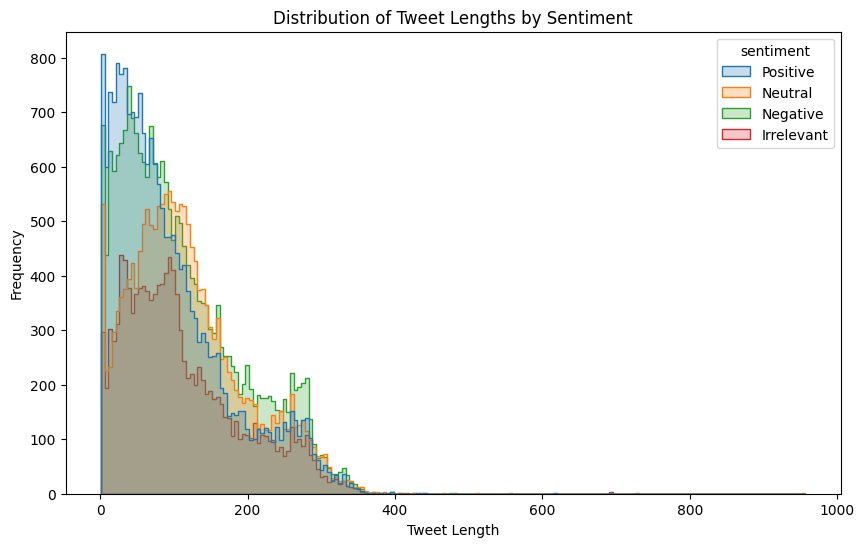

In [17]:
df['tweet_length'] = df['tweet_content'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_length', hue='sentiment', element='step', common_norm=False)
plt.title('Distribution of Tweet Lengths by Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

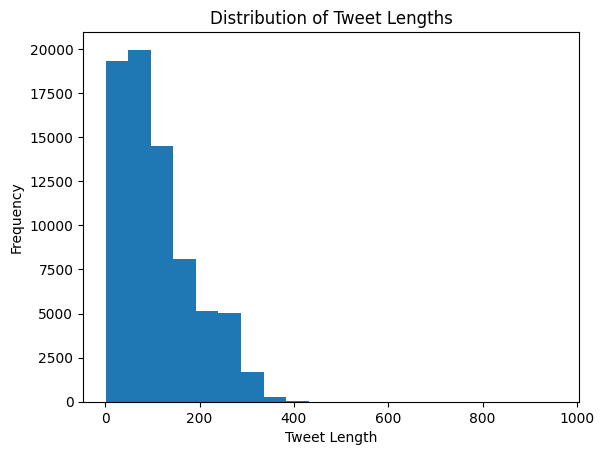

In [18]:
df['tweet_length'] = df['tweet_content'].str.len()
plt.hist(df['tweet_length'], bins=20)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

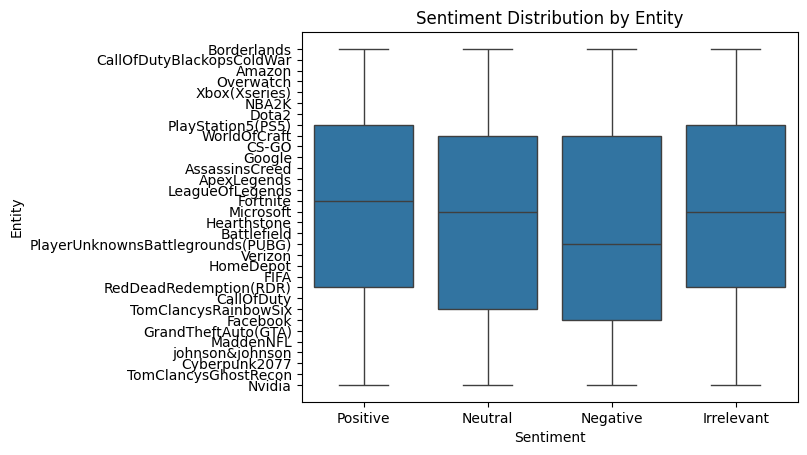

In [19]:
sns.boxplot(x='sentiment', y='entity', data=df)
plt.title('Sentiment Distribution by Entity')
plt.xlabel('Sentiment')
plt.ylabel('Entity')
plt.show()

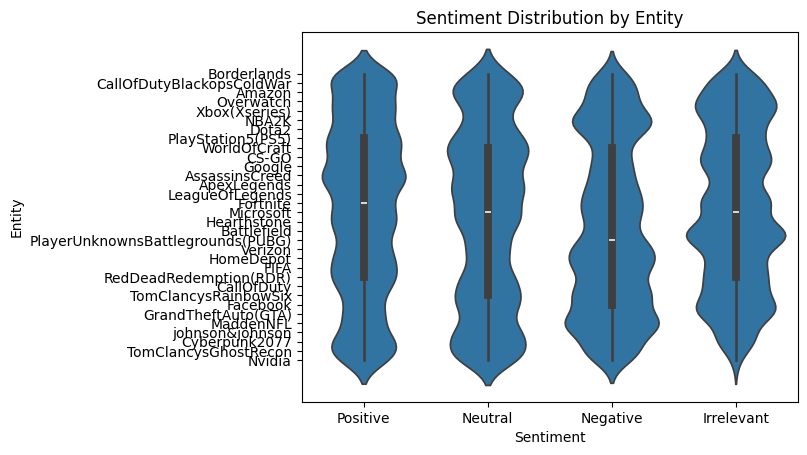

In [20]:
sns.violinplot(x='sentiment', y='entity', data=df)
plt.title('Sentiment Distribution by Entity')
plt.xlabel('Sentiment')
plt.ylabel('Entity')
plt.show()

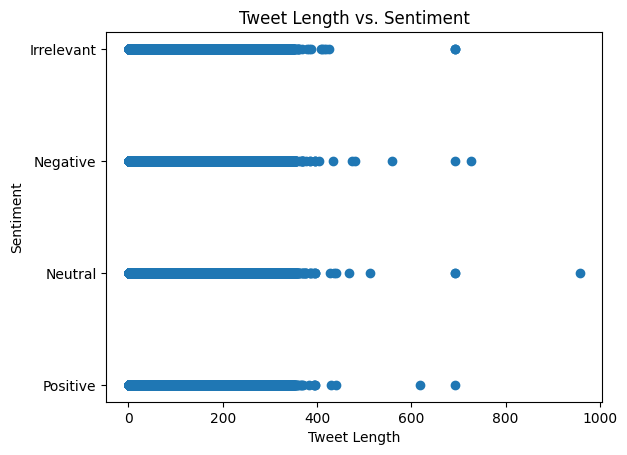

In [21]:
plt.scatter(df['tweet_length'], df['sentiment'])
plt.title('Tweet Length vs. Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Sentiment')
plt.show()

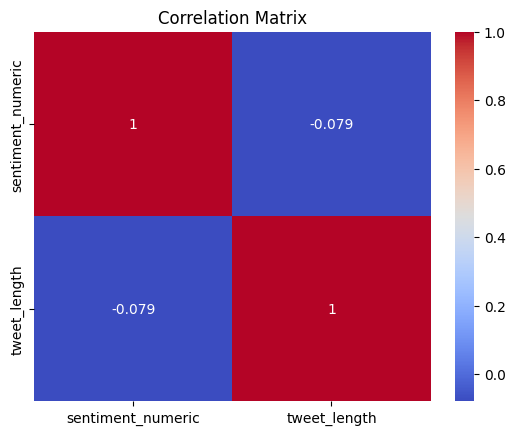

In [22]:
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)

correlation_matrix = df[['sentiment_numeric', 'tweet_length']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

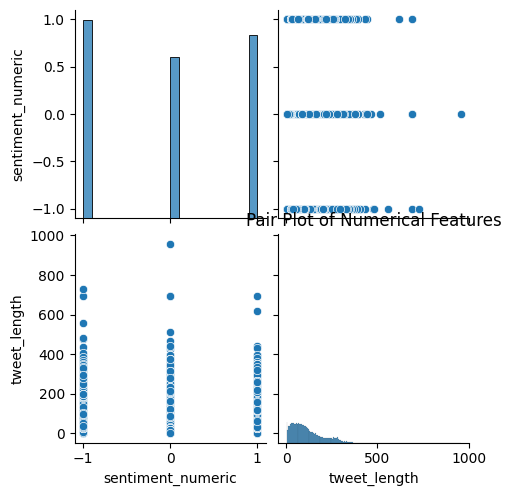

In [23]:
sns.pairplot(df[['sentiment_numeric', 'tweet_length']])
plt.title('Pair Plot of Numerical Features')
plt.show()

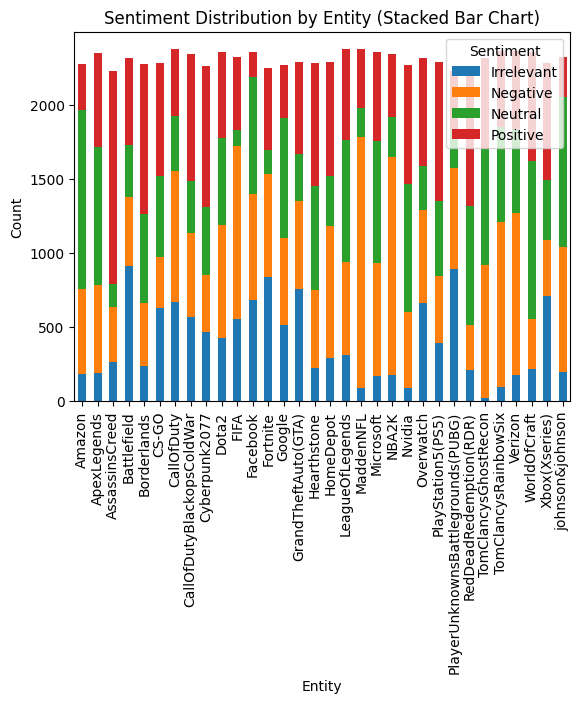

In [24]:
sentiment_counts = df.groupby(['entity', 'sentiment'])['twee_id'].count().unstack()
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Entity (Stacked Bar Chart)')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

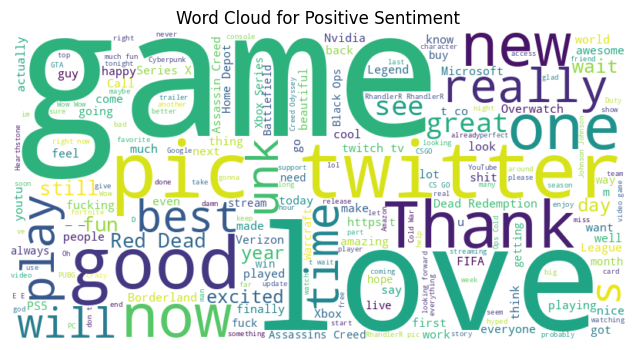

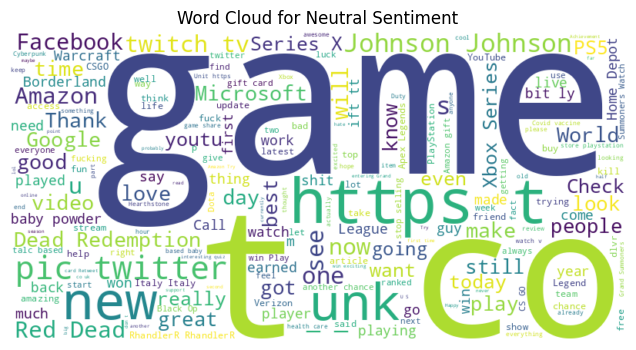

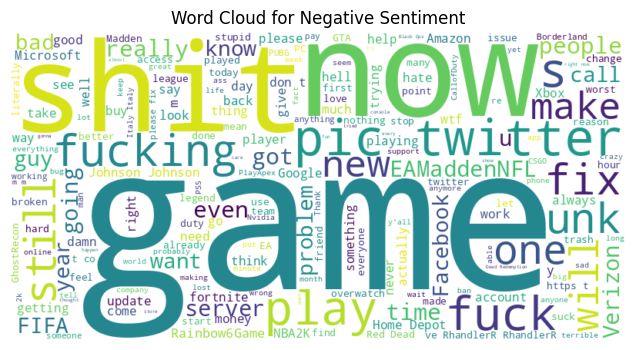

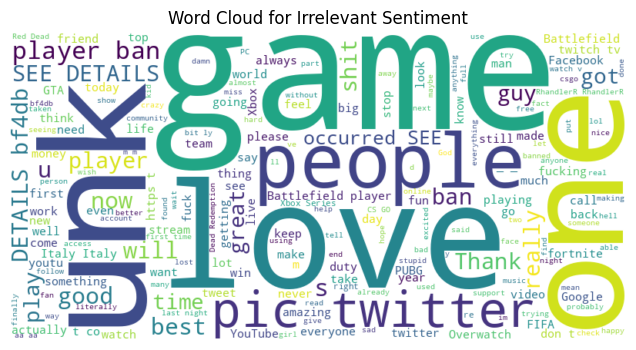

In [25]:
sentiment_texts = {
    'Positive': '',
    'Neutral': '',
    'Negative': '',
    'Irrelevant': ''
}

for sentiment, tweet in zip(df['sentiment'], df['tweet_content']):
    sentiment_texts[sentiment] += ' ' + str(tweet)

for sentiment in sentiment_texts.keys():
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(sentiment_texts[sentiment])
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

In [26]:
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [27]:
def preprocess_text(text):
    text = str(text)
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'[^\x00-\x7F]+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()

    words = [word for word in words if word not in stopwords and len(word) > 2]
    #words = [word for word in words if word not in stopwords]

    words = [lemmatizer.lemmatize(word) for word in words]

    #words = [stemmer.stem(word) for word in words]

    return " ".join(words)

In [28]:
df['clean_text'] = df['tweet_content'].apply(preprocess_text)

In [29]:
#vectorizer = TfidfVectorizer(max_features=50000)
#x = vectorizer.fit_transform(df['clean_text'])

In [30]:
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9
)
x = vectorizer.fit_transform(df['clean_text'])


In [31]:
y = df['sentiment']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

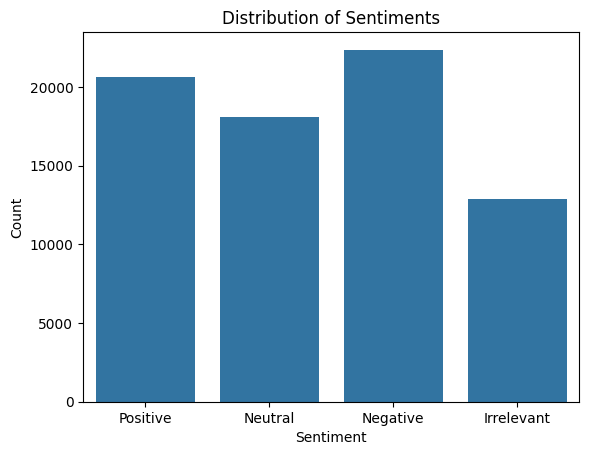

In [33]:
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [34]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

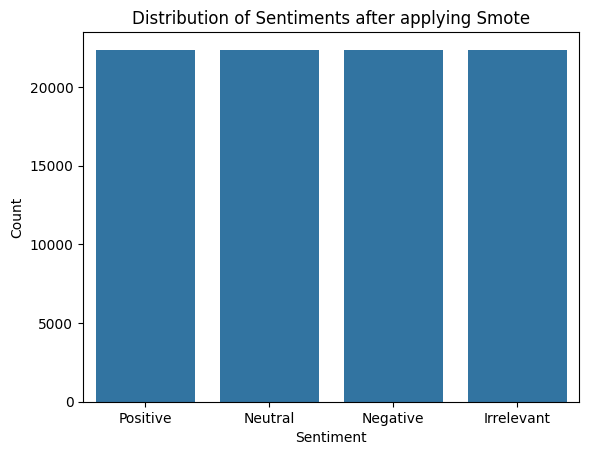

In [35]:
sns.countplot(x='sentiment', data=pd.DataFrame(y_resampled, columns=['sentiment']))
plt.title('Distribution of Sentiments after applying Smote')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [36]:
rf = RandomForestClassifier(random_state=42)

In [36]:
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
accuracy = rf.score(x_test, y_test)*100
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print('Accuracy: {:.2f}'.format(accuracy))
print('*'*50)

              precision    recall  f1-score   support

  Irrelevant       0.95      0.84      0.89      2624
    Negative       0.91      0.91      0.91      4463
     Neutral       0.84      0.91      0.88      3589
    Positive       0.90      0.90      0.90      4123

    accuracy                           0.90     14799
   macro avg       0.90      0.89      0.90     14799
weighted avg       0.90      0.90      0.90     14799

[[2207  111  164  142]
 [  37 4072  215  139]
 [  34  145 3271  139]
 [  35  128  230 3730]]
Accuracy: 89.74
**************************************************


In [37]:
knn = KNeighborsClassifier()

In [38]:
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
accuracy = knn.score(x_test, y_test)*100
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print('Accuracy: {:.2f}'.format(accuracy))
print('*'*50)

              precision    recall  f1-score   support

  Irrelevant       0.87      0.86      0.86      2624
    Negative       0.89      0.88      0.89      4463
     Neutral       0.87      0.86      0.87      3589
    Positive       0.85      0.88      0.86      4123

    accuracy                           0.87     14799
   macro avg       0.87      0.87      0.87     14799
weighted avg       0.87      0.87      0.87     14799

[[2250  104  101  169]
 [ 141 3935  146  241]
 [  83  188 3100  218]
 [ 115  201  197 3610]]
Accuracy: 87.13
**************************************************


In [38]:
svm = SVC(random_state=42)

In [40]:
svm.fit(x_train, y_train)
pred = svm.predict(x_test)
accuracy = svm.score(x_test, y_test)*100
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print('Accuracy: {:.2f}'.format(accuracy))
print('*'*50)

              precision    recall  f1-score   support

  Irrelevant       0.96      0.87      0.91      2624
    Negative       0.93      0.92      0.93      4463
     Neutral       0.85      0.93      0.89      3589
    Positive       0.91      0.91      0.91      4123

    accuracy                           0.91     14799
   macro avg       0.91      0.91      0.91     14799
weighted avg       0.91      0.91      0.91     14799

[[2280   78  153  113]
 [  35 4107  206  115]
 [  27  105 3332  125]
 [  43  117  215 3748]]
Accuracy: 91.00
**************************************************


In [39]:
x_train_ann = x_train.toarray()
x_test_ann = x_test.toarray()

In [40]:
label_encoder = LabelEncoder()
y_train_ann = label_encoder.fit_transform(y_train)
y_test_ann = label_encoder.transform(y_test)

In [41]:
ann = Sequential()
ann.add(Dense(128, activation='relu', input_shape=(x_train_ann.shape[1],)))
ann.add(Dropout(0.5))
ann.add(Dense(64, activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [42]:
ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = ann.fit(
    x_train_ann, y_train_ann,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
loss, accuracy = ann.evaluate(x_test_ann, y_test_ann)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
y_pred_ann = ann.predict(x_test_ann)
y_pred_classes = y_pred_ann.argmax(axis=1)

In [ ]:
print(classification_report(y_test_ann, y_pred_classes, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_ann, y_pred_classes))
print('Accuracy: {:.2f}'.format(accuracy))
print('*'*50)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
model_names = ['Random Forest', 'KNN', 'SVM', 'ANN']
accuracy_scores = ['89.74', '87.13','91','90']

In [35]:
data = {'Model': model_names, 'Accuracy': accuracy_scores}
df_accuracy = pd.DataFrame(data)

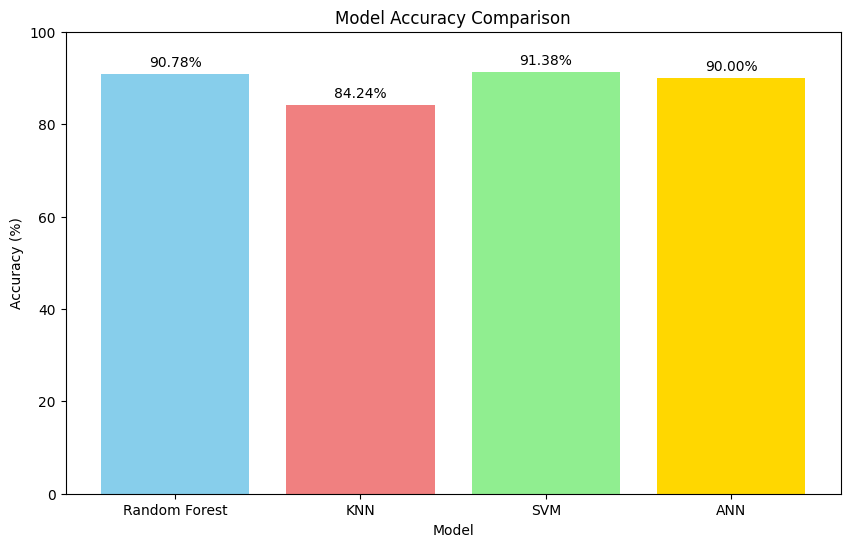

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 1, f'{score:.2f}%', ha='center', va='bottom')

plt.show()

In [39]:
new_text = ["fuck my life 😆"]
new_text_processed = [preprocess_text(text) for text in new_text]
new_text_vectorized = vectorizer.transform(new_text_processed)

predictions = svm.predict(new_text_vectorized)

predicted_sentiment = predictions[0]

print('Predicted Sentiment:', predicted_sentiment)

Predicted Sentiment: Negative
